# Comprehensive Model Comparison Analysis

This notebook compares all models tested in the Titanic survival prediction project:
- Logistic Regression (Austin)
- Support Vector Machines - Linear & RBF (SVM analysis)
- Decision Tree, Random Forest, Gradient Boosting, Bagging (Peter)
- Linear Discriminant Analysis (LDA) & Quadratic Discriminant Analysis (QDA) (Preethi)

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_validate
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

print("Libraries imported successfully!")


Libraries imported successfully!


## 1. Load and Preprocess Data

In [26]:
# Load dataset
titanic = pd.read_csv("titanic_augmented.csv")
print(f"Dataset shape: {titanic.shape}")
print(f"\nSurvival distribution:\n{titanic['Survived'].value_counts()}")
print(f"\nSurvival rate: {titanic['Survived'].mean():.2%}")

Dataset shape: (891, 26)

Survival distribution:
0    549
1    342
Name: Survived, dtype: int64

Survival rate: 38.38%


In [27]:
# Common preprocessing for all models
df = titanic.copy()

# Fill missing values
df['Age'].fillna(df['Age'].median(), inplace=True)
df['Embarked'].fillna(df['Embarked'].mode()[0], inplace=True)

# Drop columns
df.drop(columns=['Cabin', 'cabin_room_number', 'title'], inplace=True)

# Encode Sex
df['Sex'] = df['Sex'].map({'male': 1, 'female': 0})

# Drop PassengerId, Name, Ticket
df.drop(columns=['PassengerId', 'Name', 'Ticket'], inplace=True)

# One-hot encode categorical variables
df_encoded = pd.get_dummies(df, columns=['Embarked'], drop_first=True)
df_encoded = pd.get_dummies(df_encoded, columns=['Pclass'], prefix='class', drop_first=True)
df_encoded = pd.get_dummies(df_encoded, columns=['title_group'], prefix='title', drop_first=True)
df_encoded = pd.get_dummies(df_encoded, columns=['cabin_deck'], prefix='cabin', drop_first=True)

print(f"Preprocessed data shape: {df_encoded.shape}")

Preprocessed data shape: (891, 32)


In [28]:
# Split data (same split for all models)
X = df_encoded.drop(columns=['Survived'])
y = df_encoded['Survived']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")
print(f"Number of features: {X.shape[1]}")

Training set: (668, 31)
Test set: (223, 31)
Number of features: 31


In [29]:
# Alternative preprocessing for tree-based models (label encoding)
df_tree = titanic.copy()

# Fill missing values
df_tree['Age'].fillna(df_tree['Age'].median(), inplace=True)
df_tree['Embarked'].fillna(df_tree['Embarked'].mode()[0], inplace=True)

# Drop columns
df_tree.drop(columns=['Cabin', 'cabin_room_number', 'title'], inplace=True)

# Binary encoding for Sex
df_tree['Sex'] = df_tree['Sex'].map({'male': 1, 'female': 0})

# Drop PassengerId, Name, Ticket
df_tree.drop(columns=['PassengerId', 'Name', 'Ticket'], inplace=True)

# Label encode categorical variables (better for trees)
le_embarked = LabelEncoder()
df_tree['Embarked'] = le_embarked.fit_transform(df_tree['Embarked'])

le_title = LabelEncoder()
df_tree['title_group'] = le_title.fit_transform(df_tree['title_group'])

le_cabin = LabelEncoder()
df_tree['cabin_deck'] = le_cabin.fit_transform(df_tree['cabin_deck'])

# Pclass is already numeric (1, 2, 3)

print(f"Tree-optimized data shape: {df_tree.shape}")

# Split tree data
X_tree = df_tree.drop(columns=['Survived'])
y_tree = df_tree['Survived']

X_train_tree, X_test_tree, y_train_tree, y_test_tree = train_test_split(
    X_tree, y_tree, test_size=0.25, random_state=42, stratify=y_tree
)

print(f"Tree training set: {X_train_tree.shape}")
print(f"Tree test set: {X_test_tree.shape}")

Tree-optimized data shape: (891, 20)
Tree training set: (668, 19)
Tree test set: (223, 19)


### Alternative Preprocessing for Tree Models (Label Encoding)

Tree-based models can benefit from label encoding instead of one-hot encoding. Let's create an alternative dataset for trees.

## 2. Train All Models

In [30]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, BaggingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis

# Define hyperparameter grids for GridSearchCV
param_grids = {
    'Logistic Regression': {
        'C': [0.1, 0.5, 1.0, 5.0, 10.0],
        'penalty': ['l2'],
        'solver': ['lbfgs', 'saga']
    },
    'Decision Tree': {
        'max_depth': [5, 10, 15, 20],
        'min_samples_split': [10, 20, 30],
        'min_samples_leaf': [5, 10, 15]
    },
    'Random Forest': {
        'n_estimators': [50, 100, 150],
        'max_depth': [10, 15, 20],
        'min_samples_split': [10, 20],
        'min_samples_leaf': [5, 10]
    },
    'Gradient Boosting': {
        'n_estimators': [50, 100, 150],
        'learning_rate': [0.05, 0.1, 0.15],
        'max_depth': [3, 5, 7],
        'min_samples_split': [10, 20]
    },
    'Bagging': {
        'n_estimators': [50, 100, 150],
        'max_samples': [0.8, 1.0],
        'max_features': [0.8, 1.0]
    },
    'LDA': {
        'solver': ['svd', 'lsqr'],   # Stable solvers only
        'shrinkage': [None]
    },
    'QDA': {
        'reg_param': [0.0, 0.1]     # Light regularization only
    }
}

# Initialize base models (used in GridSearchCV)
base_models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42, n_jobs=-1),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'Bagging': BaggingClassifier(
        estimator=DecisionTreeClassifier(random_state=42),
        random_state=42,
        n_jobs=-1
    ),
    'LDA': LinearDiscriminantAnalysis(),
    'QDA': QuadraticDiscriminantAnalysis()
}

print(f"Total models to tune: {len(base_models)}")
print("Hyperparameter grids defined for GridSearchCV (SVM models removed)")
print("Note: LDA uses only stable solvers (svd, lsqr)")
print("Note: QDA uses only stable regularization parameters")
print("Cross-validation will use 5-fold for hyperparameter tuning")


Total models to tune: 7
Hyperparameter grids defined for GridSearchCV (SVM models removed)
Note: LDA uses only stable solvers (svd, lsqr)
Note: QDA uses only stable regularization parameters
Cross-validation will use 5-fold for hyperparameter tuning


In [31]:
# Train all models with GridSearchCV for hyperparameter tuning
results = []
trained_models = {}

def count_param_combinations(param_grid):
    """Count total parameter combinations for both dict and list-based grids"""
    if isinstance(param_grid, list):
        # For list of dicts (like LDA), sum combinations from each dict
        total = 0
        for grid_dict in param_grid:
            combo = 1
            for values in grid_dict.values():
                combo *= len(values)
            total += combo
        return total
    else:
        # For single dict, multiply all value lengths
        combo = 1
        for values in param_grid.values():
            combo *= len(values)
        return combo

for name, base_model in base_models.items():
    print(f"\n{'='*60}")
    print(f"Training {name} with GridSearchCV...")
    print(f"{'='*60}")
    
    # Determine which data to use
    if name in ['Decision Tree', 'Random Forest', 'Gradient Boosting', 'Bagging']:
        X_train_data = X_train_tree
        X_test_data = X_test_tree
        y_train_data = y_train_tree
        y_test_data = y_test_tree
        use_tree_data = True
    else:
        X_train_data = X_train_scaled
        X_test_data = X_test_scaled
        y_train_data = y_train
        y_test_data = y_test
        use_tree_data = False
    
    # Count parameter combinations
    n_combos = count_param_combinations(param_grids[name])
    
    # Perform GridSearchCV with 5-fold cross-validation
    grid_search = GridSearchCV(
        estimator=base_model,
        param_grid=param_grids[name],
        cv=5,
        scoring='f1_weighted',
        n_jobs=-1,
        verbose=0
    )
    
    print(f"Searching {n_combos} parameter combinations with 5-fold CV...")
    grid_search.fit(X_train_data, y_train_data)
    
    # Get best model
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_
    best_cv_score = grid_search.best_score_
    
    print(f"✓ Best CV F1-Score: {best_cv_score:.4f}")
    print(f"✓ Best parameters: {best_params}")
    
    # Make predictions with best model
    y_train_pred = best_model.predict(X_train_data)
    y_test_pred = best_model.predict(X_test_data)
    y_test_proba = best_model.predict_proba(X_test_data)[:, 1]
    
    # Calculate metrics on test set
    train_acc = accuracy_score(y_train_data, y_train_pred)
    test_acc = accuracy_score(y_test_data, y_test_pred)
    precision = precision_score(y_test_data, y_test_pred)
    recall = recall_score(y_test_data, y_test_pred)
    f1 = f1_score(y_test_data, y_test_pred)
    roc_auc = roc_auc_score(y_test_data, y_test_proba)
    
    # Perform cross-validation on training data for comparison metrics
    cv_scores = cross_validate(
        best_model, X_train_data, y_train_data,
        cv=5,
        scoring={'accuracy': 'accuracy', 'f1_weighted': 'f1_weighted', 'roc_auc': 'roc_auc'},
        return_train_score=False
    )
    
    cv_acc_mean = cv_scores['test_accuracy'].mean()
    cv_acc_std = cv_scores['test_accuracy'].std()
    cv_f1_mean = cv_scores['test_f1_weighted'].mean()
    cv_f1_std = cv_scores['test_f1_weighted'].std()
    cv_auc_mean = cv_scores['test_roc_auc'].mean()
    cv_auc_std = cv_scores['test_roc_auc'].std()
    
    results.append({
        'Model': name,
        'Best_Params': str(best_params),
        'GridSearch_CV_Score': best_cv_score,
        'Train_Accuracy': train_acc,
        'Test_Accuracy': test_acc,
        'CV_Accuracy_Mean': cv_acc_mean,
        'CV_Accuracy_Std': cv_acc_std,
        'Precision': precision,
        'Recall': recall,
        'F1_Score': f1,
        'CV_F1_Mean': cv_f1_mean,
        'CV_F1_Std': cv_f1_std,
        'ROC_AUC': roc_auc,
        'CV_ROC_AUC_Mean': cv_auc_mean,
        'CV_ROC_AUC_Std': cv_auc_std,
        'Overfit_Gap': train_acc - test_acc,
        'y_test_pred': y_test_pred,
        'y_test_proba': y_test_proba,
        'best_model': best_model
    })
    
    trained_models[name] = best_model
    
    print(f"Test Accuracy: {test_acc:.4f} | F1: {f1:.4f} | ROC-AUC: {roc_auc:.4f}")
    print(f"CV Accuracy: {cv_acc_mean:.4f} ± {cv_acc_std:.4f}")

# Create results DataFrame
results_df = pd.DataFrame(results)
print("\n" + "="*80)
print("All models trained and tuned with GridSearchCV!")
print("="*80)



Training Logistic Regression with GridSearchCV...
Searching 10 parameter combinations with 5-fold CV...
✓ Best CV F1-Score: 0.8387
✓ Best parameters: {'C': 0.5, 'penalty': 'l2', 'solver': 'saga'}
Test Accuracy: 0.8206 | F1: 0.7674 | ROC-AUC: 0.8586
CV Accuracy: 0.8399 ± 0.0353

Training Decision Tree with GridSearchCV...
Searching 36 parameter combinations with 5-fold CV...
✓ Best CV F1-Score: 0.7924
✓ Best parameters: {'max_depth': 10, 'min_samples_leaf': 5, 'min_samples_split': 30}
Test Accuracy: 0.7803 | F1: 0.6994 | ROC-AUC: 0.8002
CV Accuracy: 0.7934 ± 0.0146

Training Random Forest with GridSearchCV...
Searching 36 parameter combinations with 5-fold CV...
✓ Best CV F1-Score: 0.8348
✓ Best parameters: {'max_depth': 15, 'min_samples_leaf': 5, 'min_samples_split': 10, 'n_estimators': 100}
Test Accuracy: 0.7982 | F1: 0.7429 | ROC-AUC: 0.8628
CV Accuracy: 0.8368 ± 0.0241

Training Gradient Boosting with GridSearchCV...
Searching 54 parameter combinations with 5-fold CV...
✓ Best CV F

## 3. Model Performance Comparison

In [32]:
# Display comprehensive results table with cross-validation metrics
display_df = results_df[['Model', 'Train_Accuracy', 
                         'CV_Accuracy_Mean', 'CV_Accuracy_Std',
                         'Precision', 'Recall', 'F1_Score', 
                         'CV_F1_Mean', 'CV_F1_Std', 'ROC_AUC', 'CV_ROC_AUC_Mean', 'CV_ROC_AUC_Std']].copy()

display_df = display_df.sort_values('CV_Accuracy_Mean', ascending=False).reset_index(drop=True)

print("\n" + "="*130)
print("MODEL PERFORMANCE COMPARISON WITH CROSS-VALIDATION (Sorted by CV Accuracy Mean)")
print("="*130)
print(display_df.to_string(index=False))
print("="*130)

# Identify best model
best_model_name = display_df.iloc[0]['Model']
# best_acc = display_df.iloc[0]['Test_Accuracy']
best_cv_acc = display_df.iloc[0]['CV_Accuracy_Mean']
print(f"\n🏆 BEST MODEL: {best_model_name}")
print(f"   Test Accuracy: {best_acc:.4f}")
print(f"   Cross-Validation Accuracy: {best_cv_acc:.4f} (5-fold mean)")


MODEL PERFORMANCE COMPARISON WITH CROSS-VALIDATION (Sorted by CV Accuracy Mean)
              Model  Train_Accuracy  CV_Accuracy_Mean  CV_Accuracy_Std  Precision   Recall  F1_Score  CV_F1_Mean  CV_F1_Std  ROC_AUC  CV_ROC_AUC_Mean  CV_ROC_AUC_Std
  Gradient Boosting        1.000000          0.844282         0.015531   0.746988 0.720930  0.733728    0.842369   0.015110 0.836106         0.883527        0.022221
Logistic Regression        0.842814          0.839861         0.035339   0.767442 0.767442  0.767442    0.838732   0.035235 0.858598         0.860890        0.038605
      Random Forest        0.910180          0.836786         0.024077   0.730337 0.755814  0.742857    0.834841   0.023443 0.862842         0.876988        0.032024
            Bagging        0.998503          0.829290         0.028028   0.717647 0.709302  0.713450    0.826038   0.028268 0.854863         0.876970        0.025135
                LDA        0.841317          0.818920         0.033556   0.797619 0.77907

## 4. Visualizing the Desicion tree

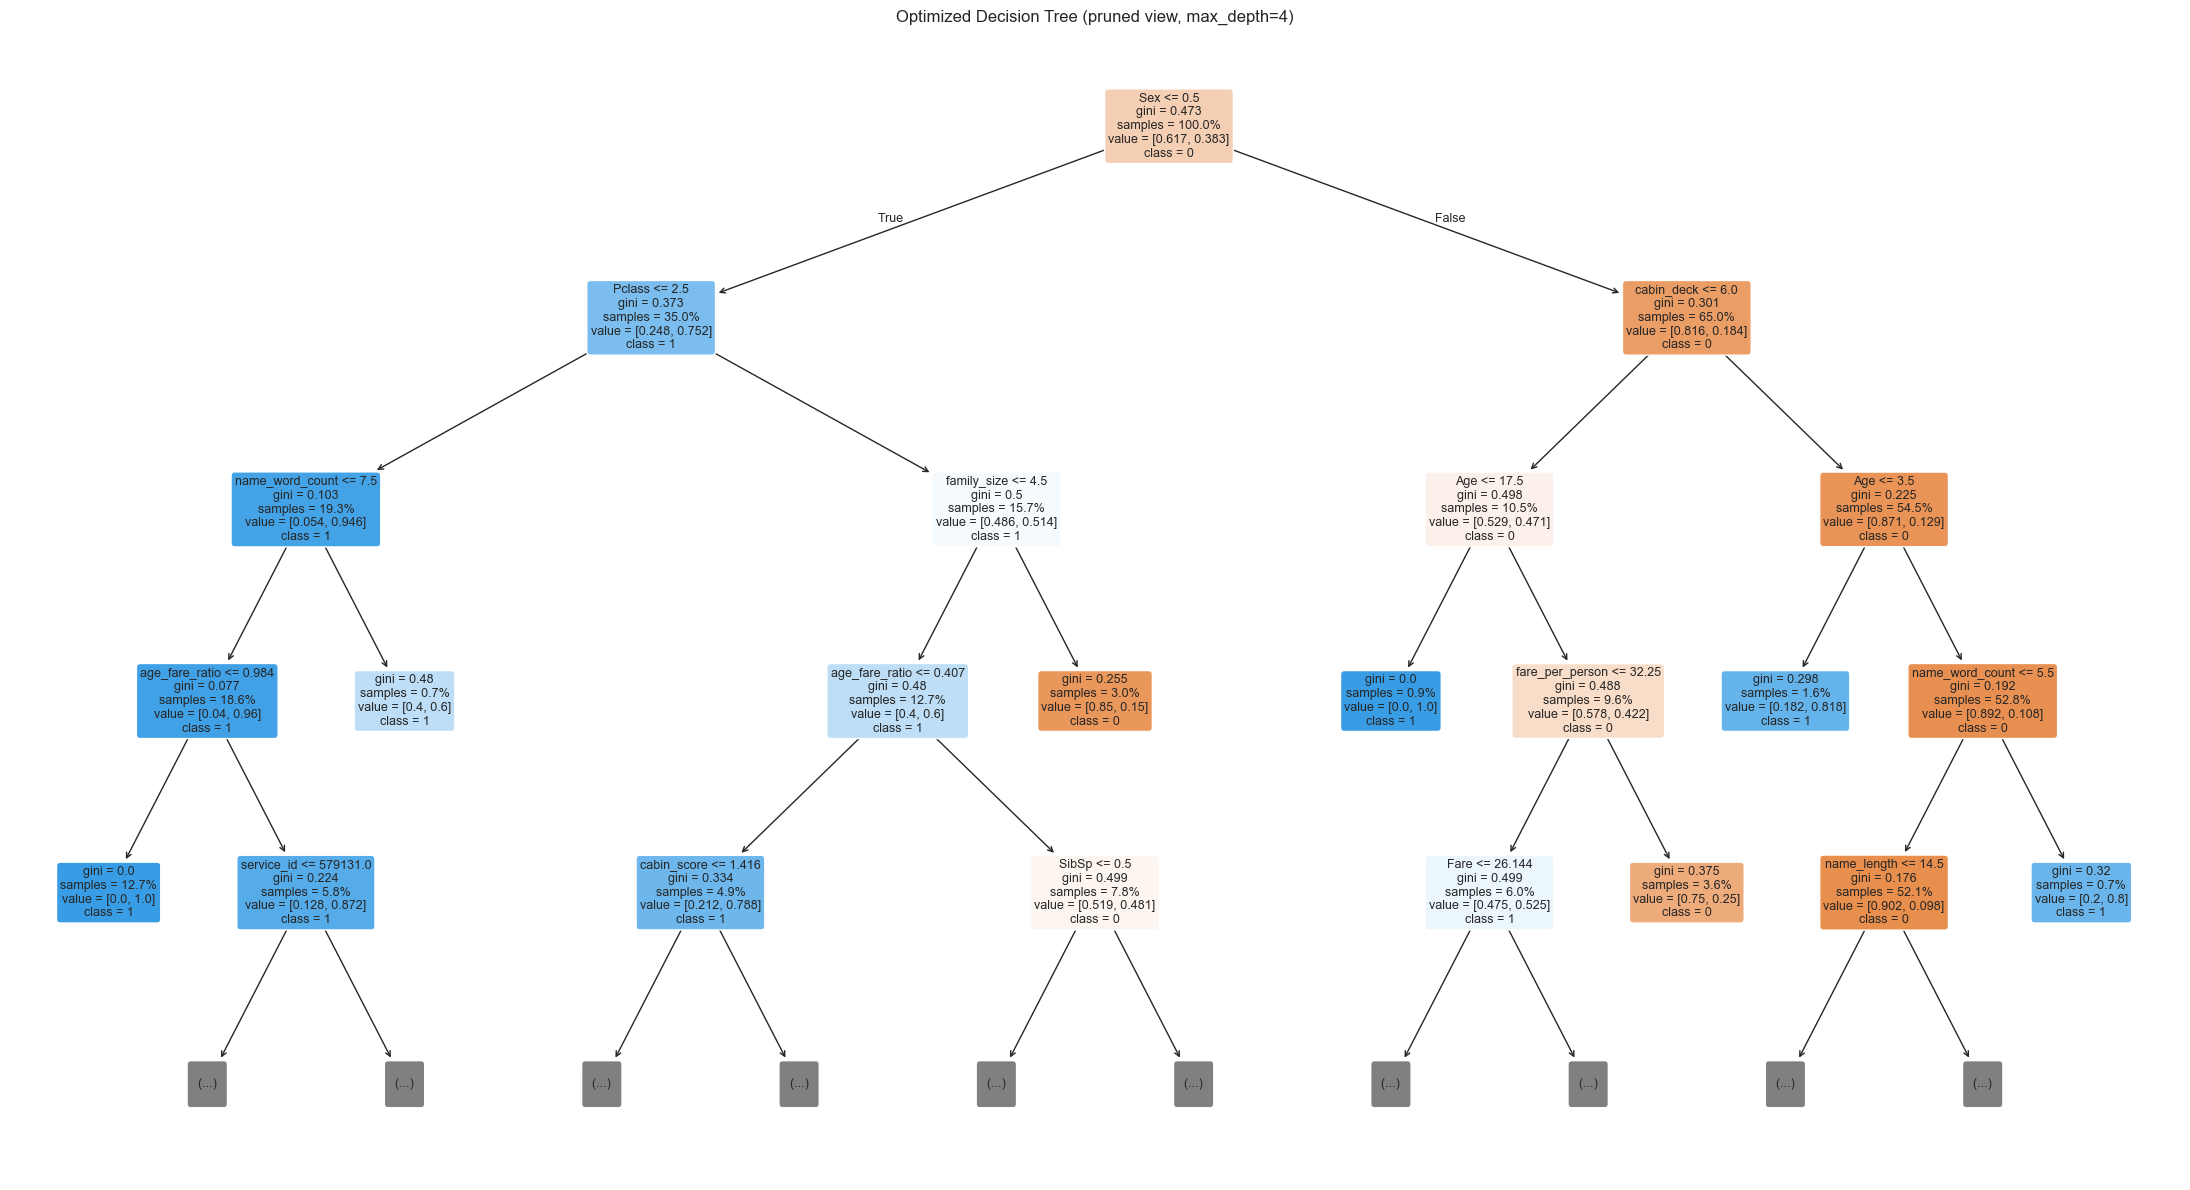

In [88]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
import pandas as pd
import numpy as np


# --- Visualize optimized Decision Tree ---
dt_best = trained_models["Decision Tree"]

# Use the correct feature names (tree models used X_train_tree)
feature_names_tree = list(X_train_tree.columns)

plt.figure(figsize=(22, 12))
plot_tree(
    dt_best,
    feature_names=feature_names_tree,
    class_names=["0", "1"],      # change if your labels are "No"/"Yes"
    filled=True,
    rounded=True,
    proportion=True,
    max_depth=4,                 # increase if you want more depth (can get huge)
    fontsize=9
)
plt.title("Optimized Decision Tree (pruned view, max_depth=4)")
plt.tight_layout()
plt.show()





## 5. Visualization 1: Overall Performance Comparison

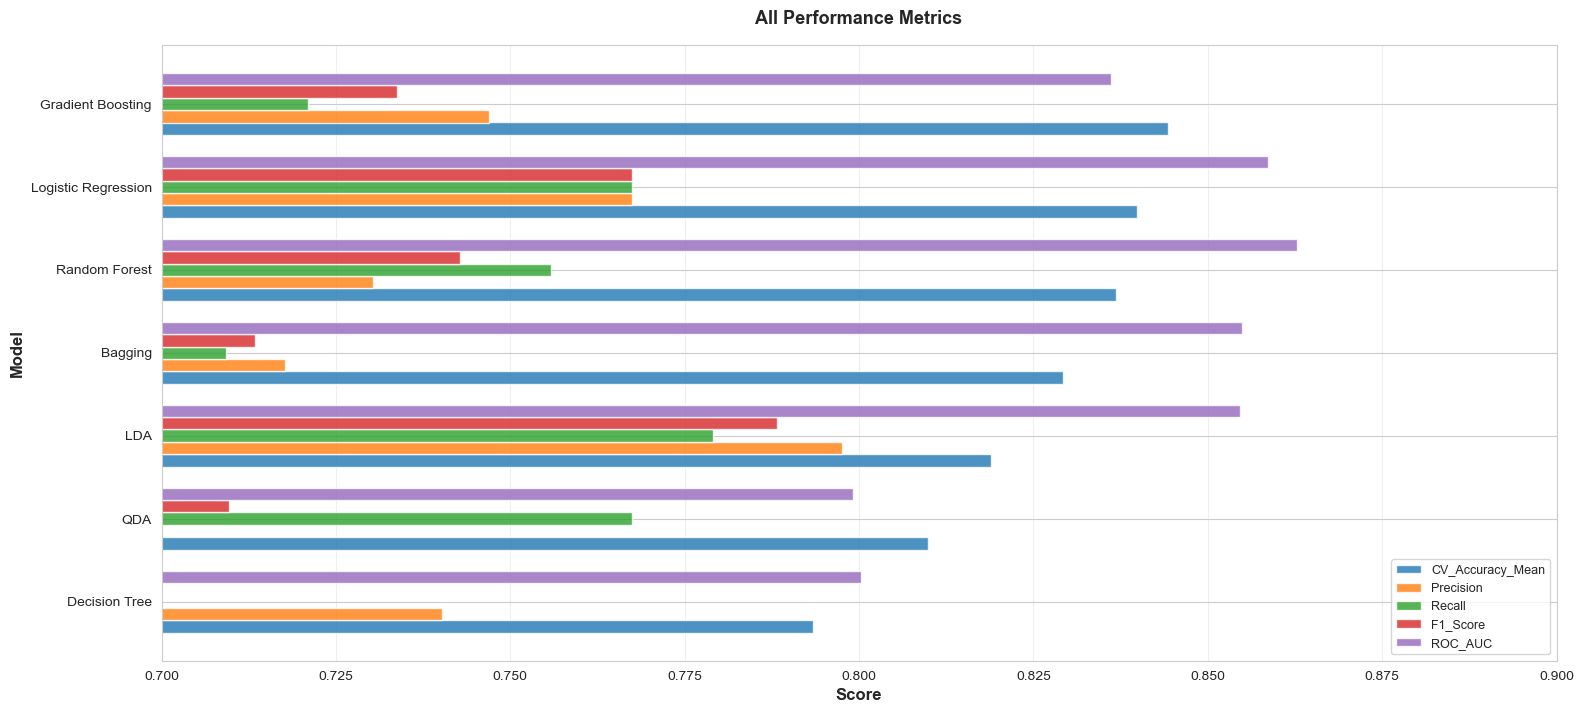

Performance Comparison with Cross-Validation - Complete


In [91]:
# Create comprehensive bar chart comparison with cross-validation
fig, ax2 = plt.subplots(figsize=(18, 8))


# Sort by test accuracy
plot_df = display_df.sort_values('CV_Accuracy_Mean', ascending=True)

# Right plot: All performance metrics

metrics = ['CV_Accuracy_Mean', 'Precision', 'Recall', 'F1_Score', 'ROC_AUC']
x = np.arange(len(plot_df))
width = 0.15

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']

for i, metric in enumerate(metrics):
    offset = (i - 2) * width
    ax2.barh(x + offset, plot_df[metric], width, label=metric, color=colors[i], alpha=0.8)

ax2.set_yticks(x)
ax2.set_yticklabels(plot_df['Model'])
ax2.set_xlabel('Score', fontsize=12, fontweight='bold')
ax2.set_ylabel('Model', fontsize=12, fontweight='bold')
ax2.set_title('All Performance Metrics', fontsize=13, fontweight='bold', pad=15)
ax2.legend(loc='lower right', fontsize=9)
ax2.set_xlim([0.7, 0.9])
ax2.grid(axis='x', alpha=0.3)

plt.show()

print("Performance Comparison with Cross-Validation - Complete")


## 6. Comparing only Cross Validation scores

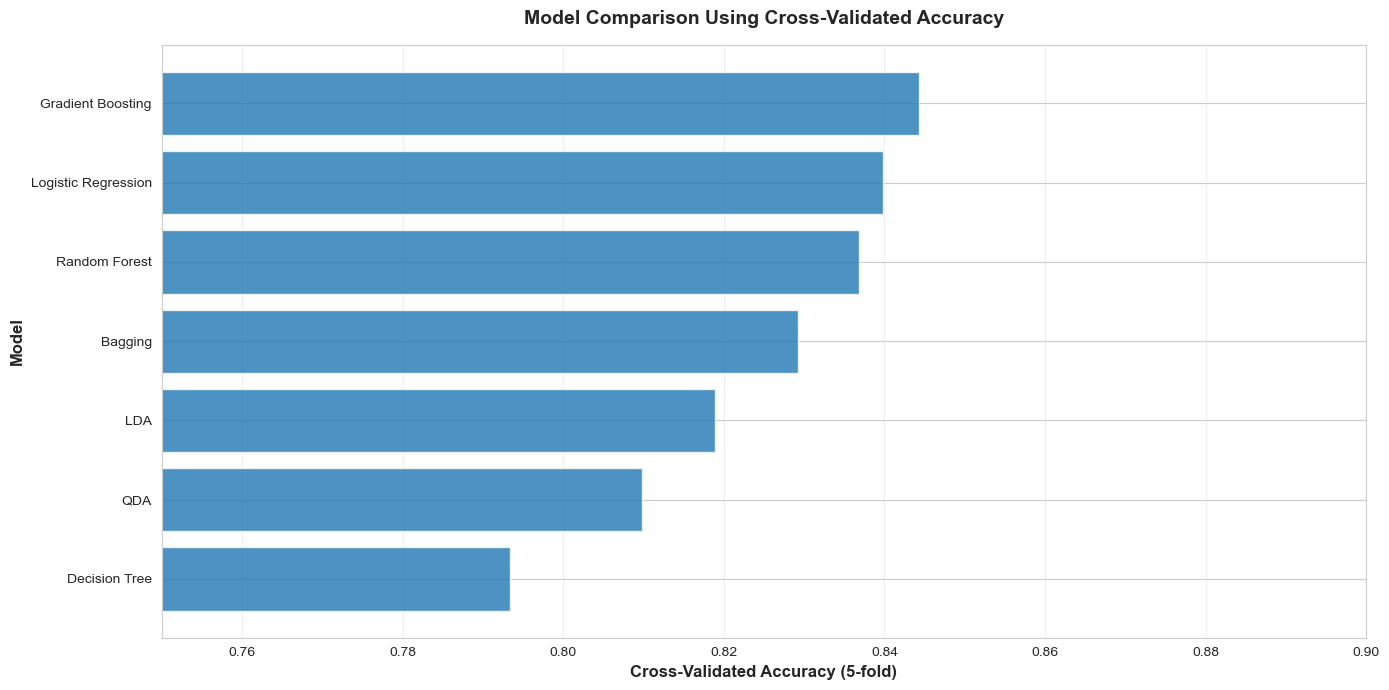

Visualization: CV Accuracy comparison across all models


In [75]:
import matplotlib.pyplot as plt
import numpy as np

# Sort models by CV accuracy
plot_df = display_df.sort_values('CV_Accuracy_Mean', ascending=True)

fig, ax = plt.subplots(figsize=(14, 7))

y = np.arange(len(plot_df))

ax.barh(
    y,
    plot_df['CV_Accuracy_Mean'],
    alpha=0.8
)

ax.set_yticks(y)
ax.set_yticklabels(plot_df['Model'])
ax.set_xlabel('Cross-Validated Accuracy (5-fold)', fontsize=12, fontweight='bold')
ax.set_ylabel('Model', fontsize=12, fontweight='bold')
ax.set_title('Model Comparison Using Cross-Validated Accuracy', fontsize=14, fontweight='bold', pad=15)

ax.set_xlim([0.75, 0.90])
ax.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

print("Visualization: CV Accuracy comparison across all models")


## 7.Overfitting analysis

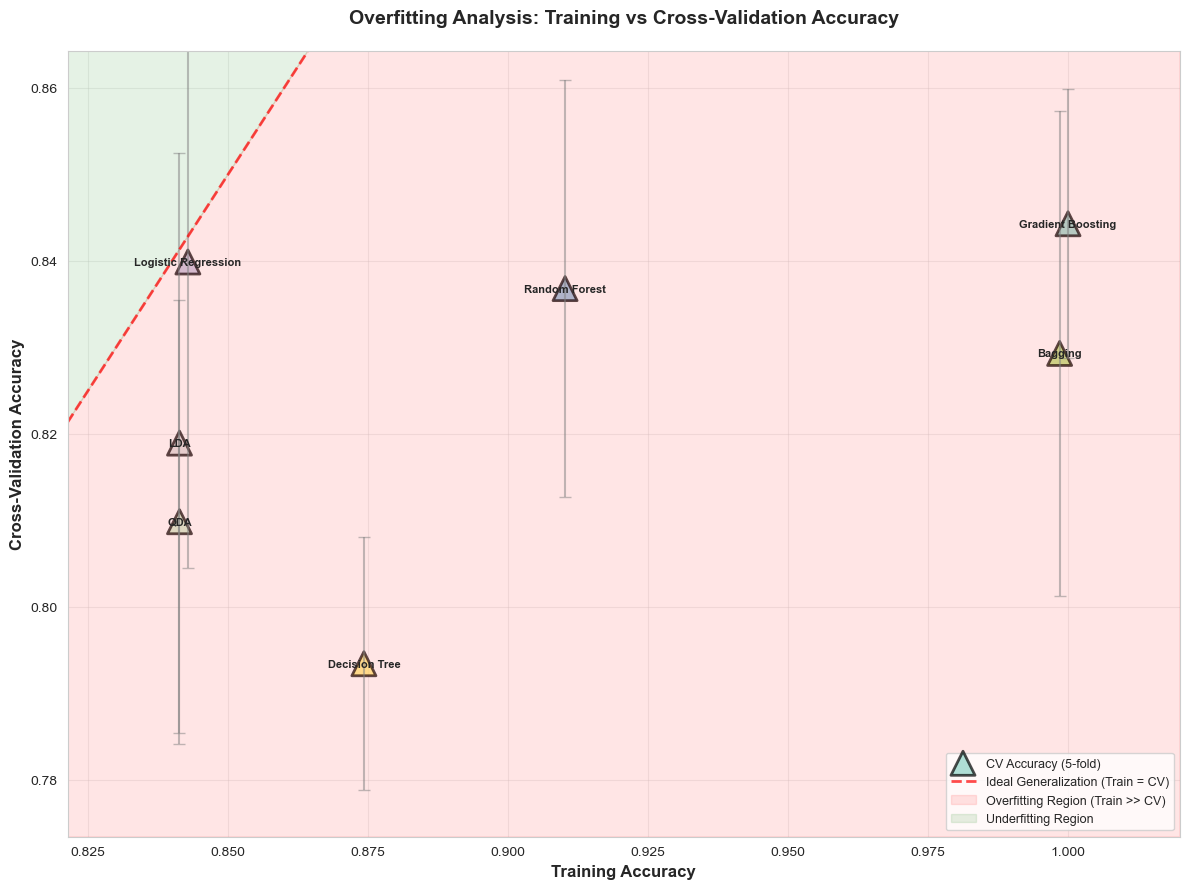

In [35]:
# Overfitting analysis scatter plot with cross-validation insights (NO test accuracy)
fig, ax = plt.subplots(figsize=(12, 9))

# Color map
colors_map = plt.cm.Set3(np.linspace(0, 1, len(display_df)))

# Scatter: Training vs CV Accuracy
scatter = ax.scatter(
    display_df['Train_Accuracy'],
    display_df['CV_Accuracy_Mean'],
    s=300,
    c=colors_map,
    alpha=0.7,
    marker='^',
    edgecolors='black',
    linewidth=2,
    label='CV Accuracy (5-fold)'
)

# Error bars for CV std
ax.errorbar(
    display_df['Train_Accuracy'],
    display_df['CV_Accuracy_Mean'],
    yerr=display_df['CV_Accuracy_Std'],
    fmt='none',
    color='gray',
    alpha=0.5,
    capsize=4,
    linewidth=1.5
)

# Dynamic axis limits with padding
x_min = display_df['Train_Accuracy'].min() - 0.02
x_max = display_df['Train_Accuracy'].max() + 0.02
y_min = display_df['CV_Accuracy_Mean'].min() - 0.02
y_max = display_df['CV_Accuracy_Mean'].max() + 0.02

# Add model labels
for _, row in display_df.iterrows():
    ax.annotate(
        row['Model'],
        (row['Train_Accuracy'], row['CV_Accuracy_Mean']),
        fontsize=8,
        ha='center',
        va='center',
        fontweight='bold'
    )

# Perfect generalization line (Train = CV)
diag_min = max(x_min, y_min)
diag_max = min(x_max, y_max)
ax.plot(
    [diag_min, diag_max],
    [diag_min, diag_max],
    'r--',
    linewidth=2,
    label='Ideal Generalization (Train = CV)',
    alpha=0.7
)

# Overfitting / underfitting regions
ax.fill_between(
    [x_min, x_max],
    [x_min, x_max],
    [y_min, y_min],
    alpha=0.1,
    color='red',
    label='Overfitting Region (Train >> CV)'
)

ax.fill_between(
    [x_min, x_max],
    [x_max, x_max],
    [x_min, x_max],
    alpha=0.1,
    color='green',
    label='Underfitting Region'
)

# Labels and styling
ax.set_xlabel('Training Accuracy', fontsize=12, fontweight='bold')
ax.set_ylabel('Cross-Validation Accuracy', fontsize=12, fontweight='bold')
ax.set_title(
    'Overfitting Analysis: Training vs Cross-Validation Accuracy',
    fontsize=14,
    fontweight='bold',
    pad=20
)

ax.set_xlim([x_min, x_max])
ax.set_ylim([y_min, y_max])
ax.legend(loc='lower right', fontsize=9)
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()


## 8. ROC Curves Comparison

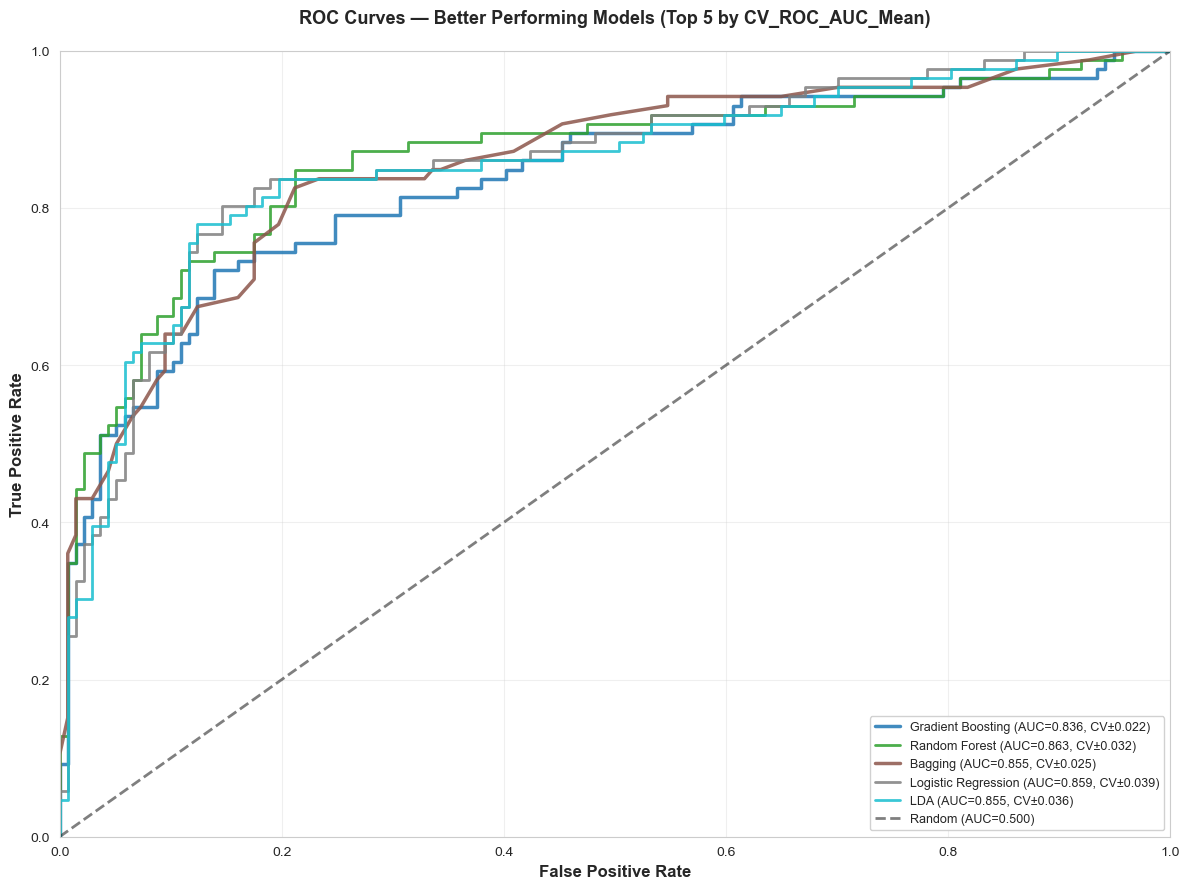

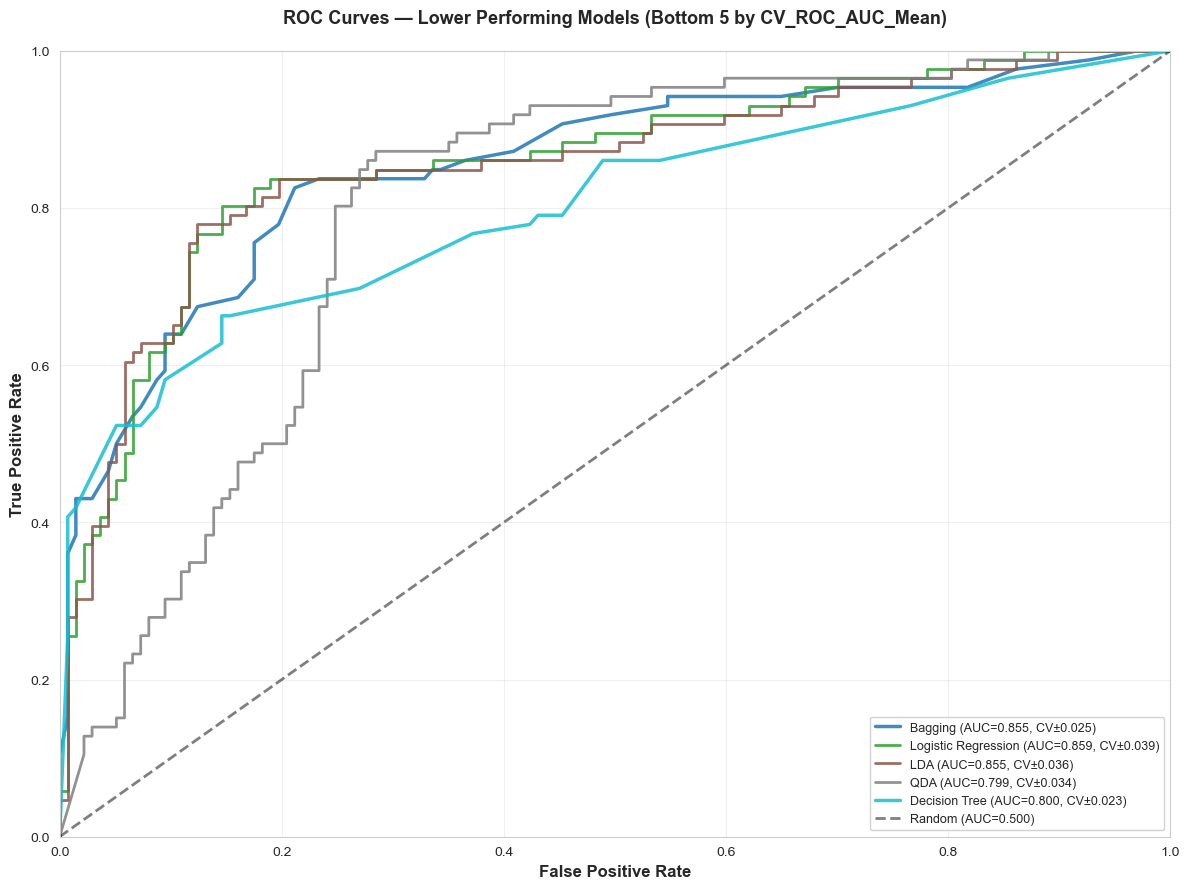

In [76]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

# --- Choose how to split ---
split_metric = "CV_ROC_AUC_Mean"   # or "CV_Accuracy_Mean" or "CV_F1_Mean"
n_top = 5                          # top 5 vs bottom 5 (adjust as you like)

# Sort models by the metric (higher = better)
sorted_df = results_df.sort_values(split_metric, ascending=False).reset_index(drop=True)

top_df = sorted_df.head(n_top)
bottom_df = sorted_df.tail(n_top)

def plot_roc_group(df_group, title):
    fig, ax = plt.subplots(figsize=(12, 9))
    colors = plt.cm.tab10(np.linspace(0, 1, len(df_group)))

    for idx, row in df_group.reset_index(drop=True).iterrows():
        # Pick correct y_test
        if row['Model'] in ['Decision Tree', 'Random Forest', 'Gradient Boosting', 'Bagging']:
            fpr, tpr, _ = roc_curve(y_test_tree, row['y_test_proba'])
        else:
            fpr, tpr, _ = roc_curve(y_test, row['y_test_proba'])

        # Line width based on CV consistency (lower std = thicker line)
        cv_std = row['CV_ROC_AUC_Std']
        line_width = 3.0 if cv_std < 0.02 else 2.5 if cv_std < 0.03 else 2.0

        ax.plot(
            fpr, tpr,
            label=f"{row['Model']} (AUC={row['ROC_AUC']:.3f}, CV±{cv_std:.3f})",
            linewidth=line_width,
            color=colors[idx],
            alpha=0.85
        )

    # Random baseline
    ax.plot([0, 1], [0, 1], 'k--', linewidth=2, label='Random (AUC=0.500)', alpha=0.5)

    ax.set_xlabel('False Positive Rate', fontsize=12, fontweight='bold')
    ax.set_ylabel('True Positive Rate', fontsize=12, fontweight='bold')
    ax.set_title(title, fontsize=13, fontweight='bold', pad=20)
    ax.legend(loc='lower right', fontsize=9, framealpha=0.9)
    ax.grid(alpha=0.3)
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    plt.tight_layout()
    plt.show()

# --- Plot two groups ---
plot_roc_group(top_df, f"ROC Curves — Better Performing Models (Top {n_top} by {split_metric})")
plot_roc_group(bottom_df, f"ROC Curves — Lower Performing Models (Bottom {n_top} by {split_metric})")


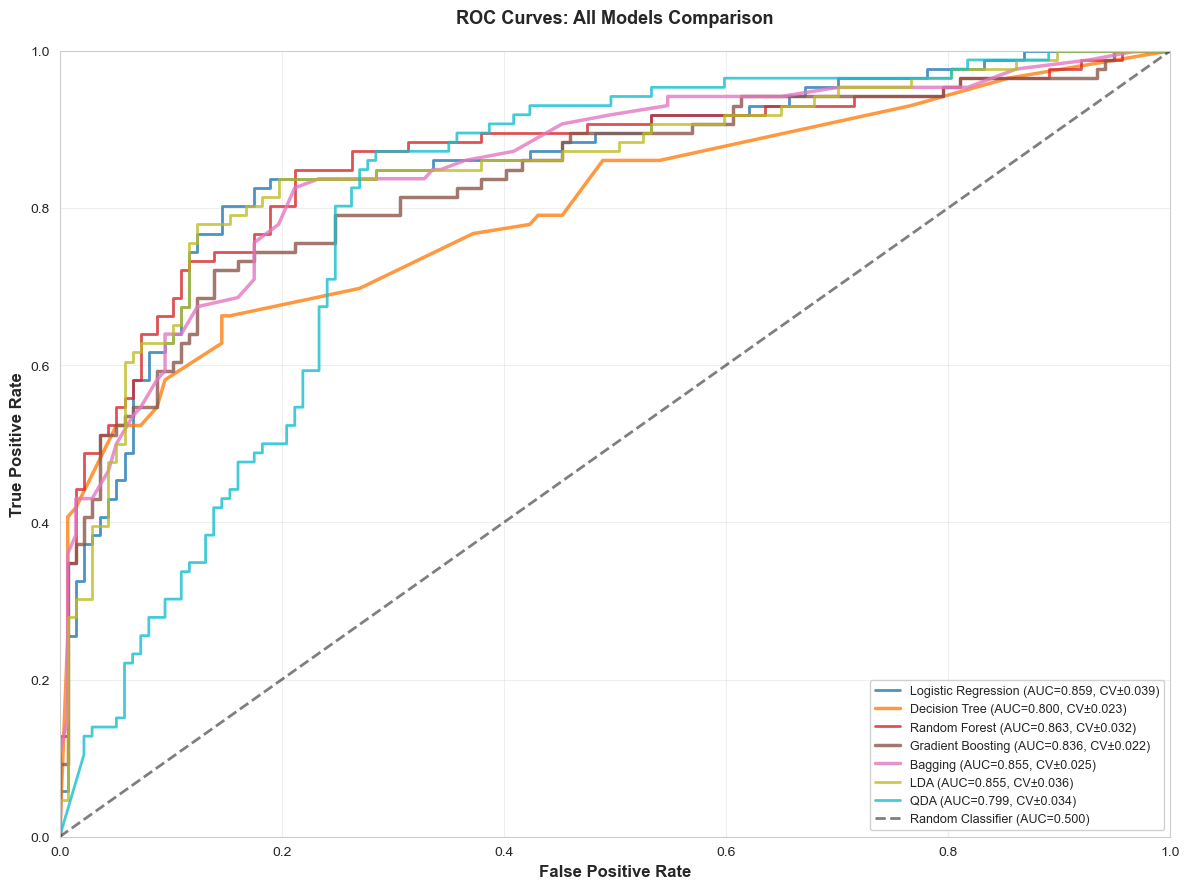

Visualization 4: ROC Curves Comparison - Complete


In [77]:
# Plot ROC curves for all models with cross-validation reliability indicators
fig, ax = plt.subplots(figsize=(12, 9))

colors = plt.cm.tab10(np.linspace(0, 1, len(results_df)))

for idx, row in results_df.iterrows():
    # Use appropriate y_test based on model type
    if row['Model'] in ['Decision Tree', 'Random Forest', 'Gradient Boosting', 'Bagging']:
        fpr, tpr, _ = roc_curve(y_test_tree, row['y_test_proba'])
    else:
        fpr, tpr, _ = roc_curve(y_test, row['y_test_proba'])
    
    # Line width based on CV consistency (lower std = thicker line)
    cv_std = row['CV_ROC_AUC_Std']
    line_width = 3.0 if cv_std < 0.02 else 2.5 if cv_std < 0.03 else 2.0
    
    ax.plot(fpr, tpr, label=f"{row['Model']} (AUC={row['ROC_AUC']:.3f}, CV±{cv_std:.3f})", 
            linewidth=line_width, color=colors[idx], alpha=0.8)

# Add diagonal line (random classifier)
ax.plot([0, 1], [0, 1], 'k--', linewidth=2, label='Random Classifier (AUC=0.500)', alpha=0.5)

ax.set_xlabel('False Positive Rate', fontsize=12, fontweight='bold')
ax.set_ylabel('True Positive Rate', fontsize=12, fontweight='bold')
ax.set_title('ROC Curves: All Models Comparison', 
             fontsize=13, fontweight='bold', pad=20)
ax.legend(loc='lower right', fontsize=9, framealpha=0.9)
ax.grid(alpha=0.3)
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])

plt.tight_layout()
plt.show()

print("Visualization 4: ROC Curves Comparison - Complete")


## 9. Statistical Summary and Insights

In [60]:
# Statistical summary with cross-validation analysis
print("\n" + "="*120)
print("STATISTICAL SUMMARY ACROSS ALL MODELS (Including Cross-Validation Analysis)")
print("="*120)

metrics_stats = display_df[['Test_Accuracy', 'CV_Accuracy_Mean', 'CV_Accuracy_Std',
                             'Precision', 'Recall', 'F1_Score', 'CV_F1_Mean', 'ROC_AUC', 'Overfit_Gap']].describe()
print(metrics_stats.T)

print("\n" + "="*120)
print("CROSS-VALIDATION CONSISTENCY ANALYSIS")
print("="*120)
print("\nModels ranked by CV stability (lower std = more consistent):")
cv_consistency = display_df[['Model', 'CV_Accuracy_Mean', 'CV_Accuracy_Std', 
                             'CV_F1_Mean', 'CV_F1_Std', 'CV_ROC_AUC_Mean', 'CV_ROC_AUC_Std']].copy()
cv_consistency['Total_Std'] = (cv_consistency['CV_Accuracy_Std'] + 
                                cv_consistency['CV_F1_Std'] + 
                                cv_consistency['CV_ROC_AUC_Std']) / 3
cv_consistency = cv_consistency.sort_values('Total_Std')
print(cv_consistency.to_string(index=False))

print("\n" + "="*120)
print("TEST ACCURACY vs CROSS-VALIDATION ACCURACY (Generalization Gap)")
print("="*120)
gap_analysis = display_df[['Model', 'Test_Accuracy', 'CV_Accuracy_Mean', 
                            'CV_Accuracy_Std', 'Overfit_Gap']].copy()
gap_analysis['Gen_Gap'] = abs(gap_analysis['Test_Accuracy'] - gap_analysis['CV_Accuracy_Mean'])
gap_analysis = gap_analysis.sort_values('Gen_Gap')
print(gap_analysis.to_string(index=False))

print("\n" + "="*120)
print("KEY INSIGHTS FROM CROSS-VALIDATION ANALYSIS")
print("="*120)

# Best performers
best_acc = display_df.loc[display_df['Test_Accuracy'].idxmax()]
best_cv_acc = display_df.loc[display_df['CV_Accuracy_Mean'].idxmax()]
best_f1 = display_df.loc[display_df['F1_Score'].idxmax()]
least_overfit = display_df.loc[display_df['Overfit_Gap'].idxmin()]
most_stable = cv_consistency.iloc[0]

print(f"\n🏆 Best Test Accuracy: {best_acc['Model']} ({best_acc['Test_Accuracy']:.4f})")
print(f"🏆 Best Cross-Validation Accuracy: {best_cv_acc['Model']} ({best_cv_acc['CV_Accuracy_Mean']:.4f} ± {best_cv_acc['CV_Accuracy_Std']:.4f})")
print(f"🏆 Best F1-Score: {best_f1['Model']} ({best_f1['F1_Score']:.4f})")
print(f"🏆 Least Overfitting: {least_overfit['Model']} (Gap: {least_overfit['Overfit_Gap']:.4f})")
print(f"🏆 Most CV Stable: {most_stable['Model']} (Avg Std: {most_stable['Total_Std']:.4f})")

# Performance range
print(f"\n📈 Test Accuracy Range: {display_df['Test_Accuracy'].min():.4f} - {display_df['Test_Accuracy'].max():.4f}")
print(f"📈 CV Accuracy Range: {display_df['CV_Accuracy_Mean'].min():.4f} - {display_df['CV_Accuracy_Mean'].max():.4f}")
print(f"📈 CV Stability (Avg Std): {cv_consistency['Total_Std'].mean():.4f}")

print("\n✅ NOTE: Cross-validation provides robust performance estimates by:")
print("   • Evaluating on multiple data splits (5-fold)")
print("   • Reducing variance from random train-test split")
print("   • Better generalization assessment")
print("   • Standard deviation shows model consistency")



STATISTICAL SUMMARY ACROSS ALL MODELS (Including Cross-Validation Analysis)
                  count      mean       std       min       25%       50%  \
Test_Accuracy       9.0  0.794220  0.027865  0.757848  0.780269  0.798206   
CV_Accuracy_Mean    9.0  0.826674  0.016735  0.793413  0.818920  0.829323   
CV_Accuracy_Std     9.0  0.027249  0.008863  0.013185  0.024077  0.028028   
Precision           9.0  0.736681  0.040066  0.660000  0.717647  0.740260   
Recall              9.0  0.728682  0.049674  0.639535  0.709302  0.755814   
F1_Score            9.0  0.731749  0.037074  0.670732  0.709677  0.733728   
CV_F1_Mean          9.0  0.825007  0.016603  0.792445  0.818126  0.828048   
ROC_AUC             9.0  0.837464  0.023968  0.799143  0.830674  0.840095   
Overfit_Gap         9.0  0.104649  0.081359  0.002752  0.023677  0.093982   

                       75%       max  
Test_Accuracy     0.816143  0.838565  
CV_Accuracy_Mean  0.836786  0.847290  
CV_Accuracy_Std   0.033556  0.03853

## 10. Export Results

In [63]:
# Save detailed results to CSV
export_df = display_df[['Model', 'Test_Accuracy', 'Train_Accuracy', 'Overfit_Gap',
                         'CV_Accuracy_Mean', 'CV_Accuracy_Std',
                         'Precision', 'Recall', 'F1_Score', 
                         'CV_F1_Mean', 'CV_F1_Std',
                         'ROC_AUC', 'CV_ROC_AUC_Mean', 'CV_ROC_AUC_Std']].copy().round(3)
export_df.to_csv('model_comparison_results_with_cv.csv', index=False)
print("✅ Detailed results with cross-validation exported to 'model_comparison_results_with_cv.csv'")

# Save hyperparameter tuning results
hp_export = results_df[['Model', 'Best_Params', 'GridSearch_CV_Score', 'Test_Accuracy']].copy()
hp_export.to_csv('hyperparameter_tuning_results.csv', index=False)
print("✅ Hyperparameter tuning results exported to 'hyperparameter_tuning_results.csv'")


✅ Detailed results with cross-validation exported to 'model_comparison_results_with_cv.csv'
✅ Hyperparameter tuning results exported to 'hyperparameter_tuning_results.csv'


## 11.Feature importance

In [67]:
from sklearn.inspection import permutation_importance
import pandas as pd

def perm_importance_train_only(model, X_train, y_train, feature_names,
                               scoring="roc_auc", n_repeats=30, random_state=42):
    perm = permutation_importance(
        model,
        X_train,
        y_train,
        scoring=scoring,
        n_repeats=n_repeats,
        random_state=random_state,
        n_jobs=-1
    )

    return (
        pd.DataFrame({
            "Feature": feature_names,
            "Importance_Mean": perm.importances_mean,
            "Importance_Std": perm.importances_std
        })
        .sort_values("Importance_Mean", ascending=False)
        .reset_index(drop=True)
    )


In [73]:
tree_models = ['Decision Tree', 'Random Forest', 'Gradient Boosting', 'Bagging']
all_perm_importances = {}

for name, model in trained_models.items():

    if name in tree_models:
        Xtr = X_train_tree
        ytr = y_train_tree
        feature_names = X_train_tree.columns
    else:
        Xtr = X_train_scaled
        ytr = y_train
        feature_names = X_train.columns   # original (pre-scaled) names

    perm_df = perm_importance_train_only(
        model,
        Xtr,
        ytr,
        feature_names=feature_names,
        scoring="roc_auc"
    )

    all_perm_importances[name] = perm_df


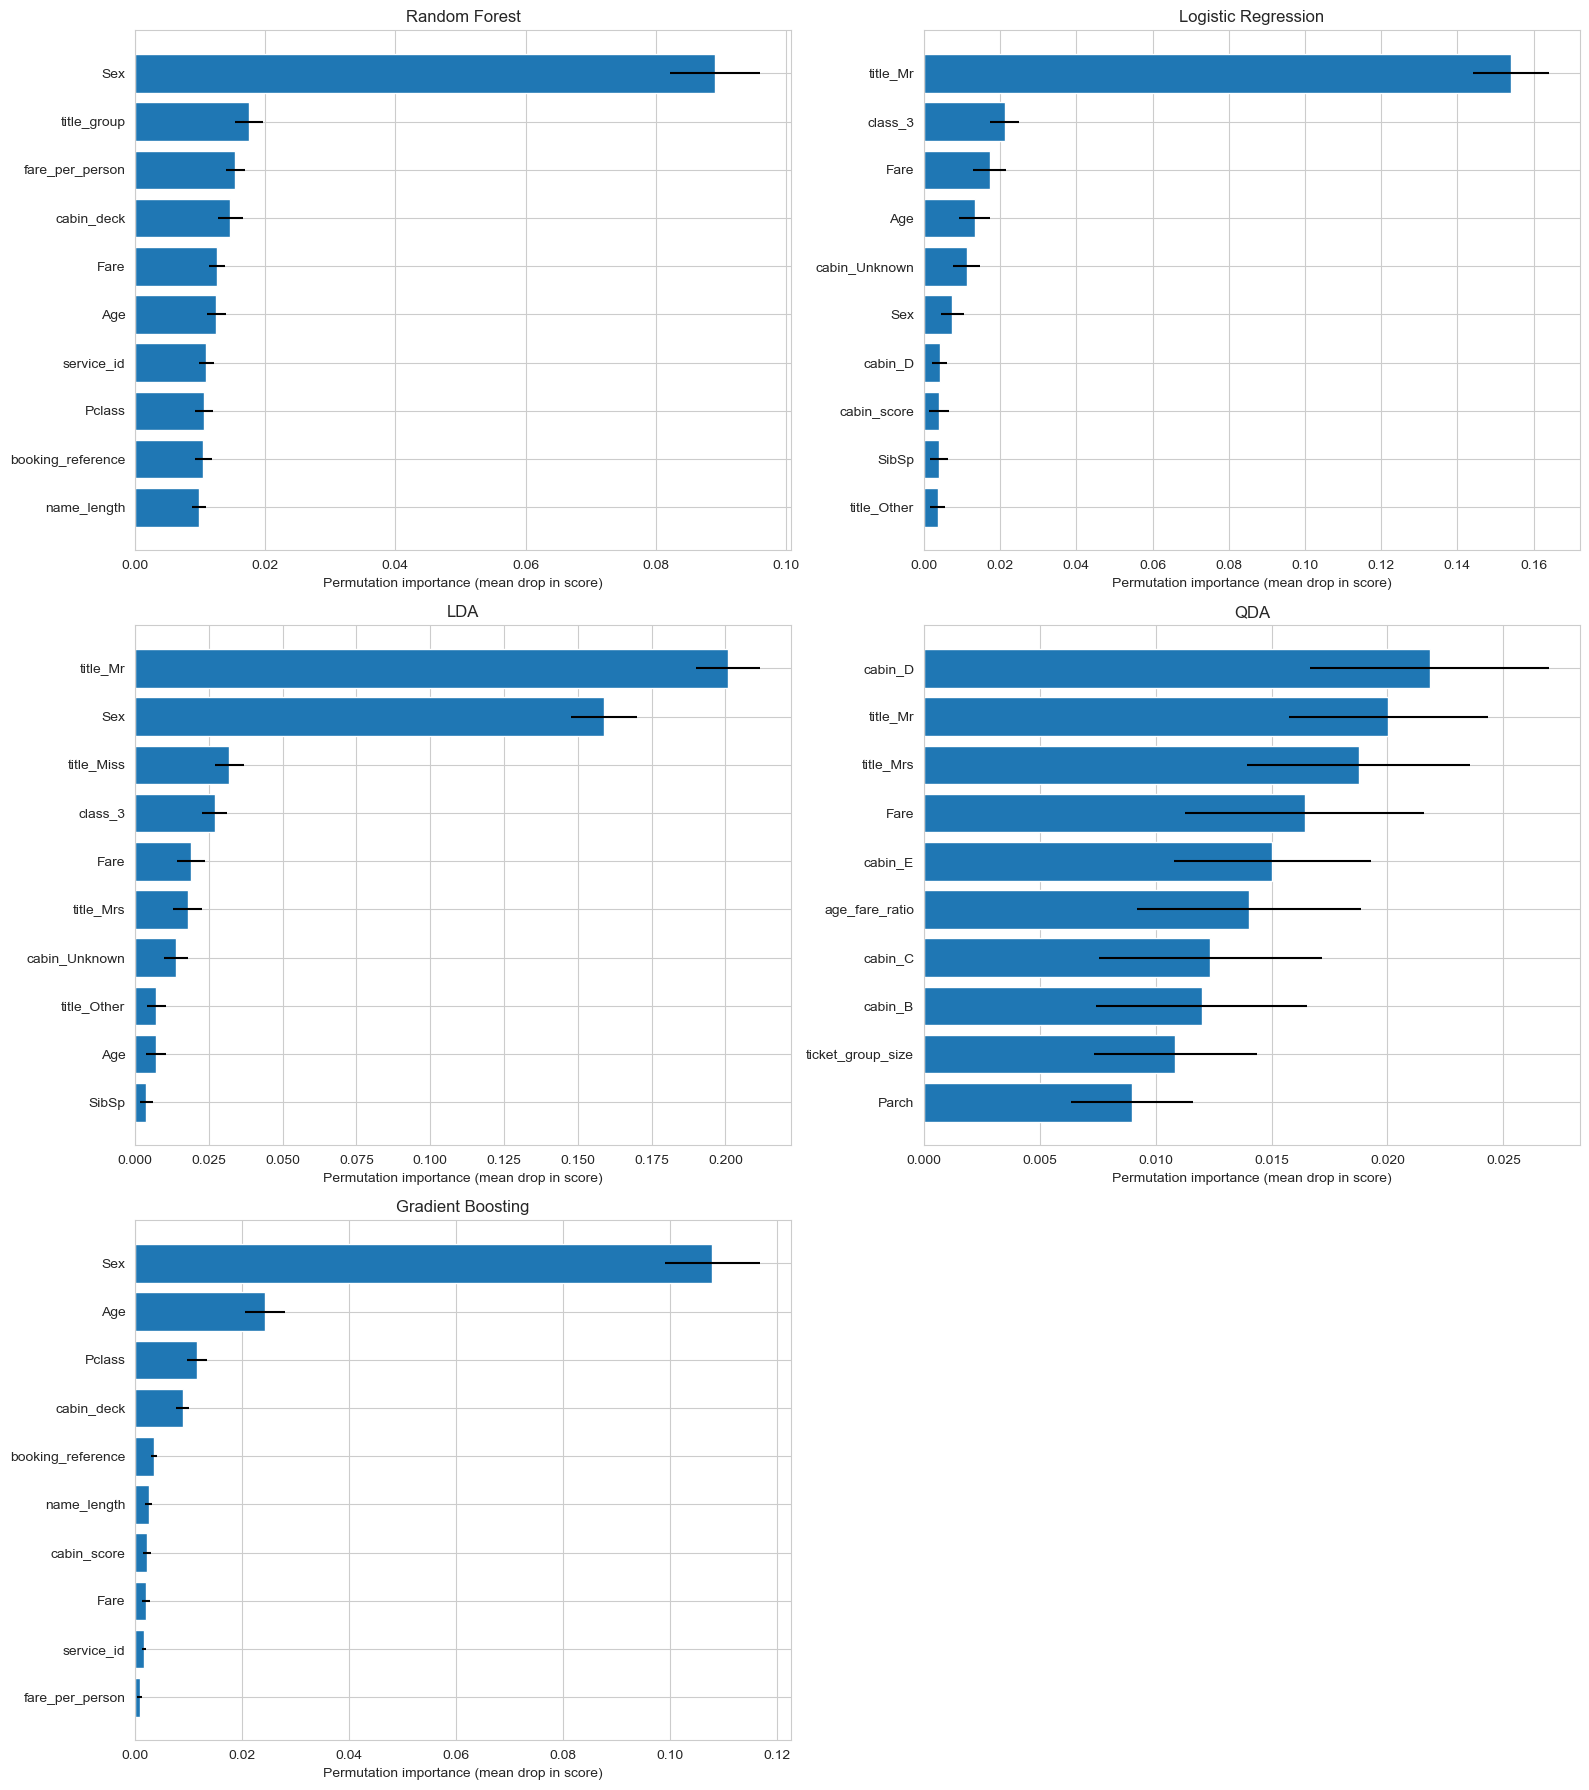

In [74]:
import matplotlib.pyplot as plt

def plot_perm_importance_for_model(all_perm_importances, model_name, top_n=20):
    df = all_perm_importances[model_name].head(top_n).copy()
    df = df.iloc[::-1]  # reverse so biggest is on top in barh

    plt.figure(figsize=(10, 7))
    plt.barh(df["Feature"], df["Importance_Mean"], xerr=df["Importance_Std"])
    plt.xlabel("Permutation importance (mean drop in score)")
    plt.title(f"Top {top_n} permutation importances — {model_name}")
    plt.tight_layout()
    plt.show()

# Example:
import matplotlib.pyplot as plt

models_to_plot = [
    "Random Forest",
    "Logistic Regression",
    "LDA",
    "QDA",
    "Gradient Boosting"
]

def plot_perm_importance_grid(all_perm_importances, models, top_n=10):
    fig, axes = plt.subplots(3, 2, figsize=(16, 18))
    axes = axes.flatten()

    for ax, model_name in zip(axes, models):
        df = all_perm_importances[model_name].head(top_n).copy()
        df = df.iloc[::-1]  # biggest on top

        ax.barh(df["Feature"], df["Importance_Mean"], xerr=df["Importance_Std"])
        ax.set_title(model_name)
        ax.set_xlabel("Permutation importance (mean drop in score)")
        ax.set_ylabel("")

    # Hide any unused subplots (since you have 5 models, not 6)
    for ax in axes[len(models):]:
        ax.axis("off")


    plt.tight_layout()
    plt.show()

# Run it
plot_perm_importance_grid(all_perm_importances, models_to_plot, top_n=10)


## 10. Test Accuracy comparison

                 Model  Test_Accuracy
6                  QDA       0.757848
1        Decision Tree       0.780269
4              Bagging       0.780269
2        Random Forest       0.798206
3    Gradient Boosting       0.798206
0  Logistic Regression       0.820628
5                  LDA       0.838565


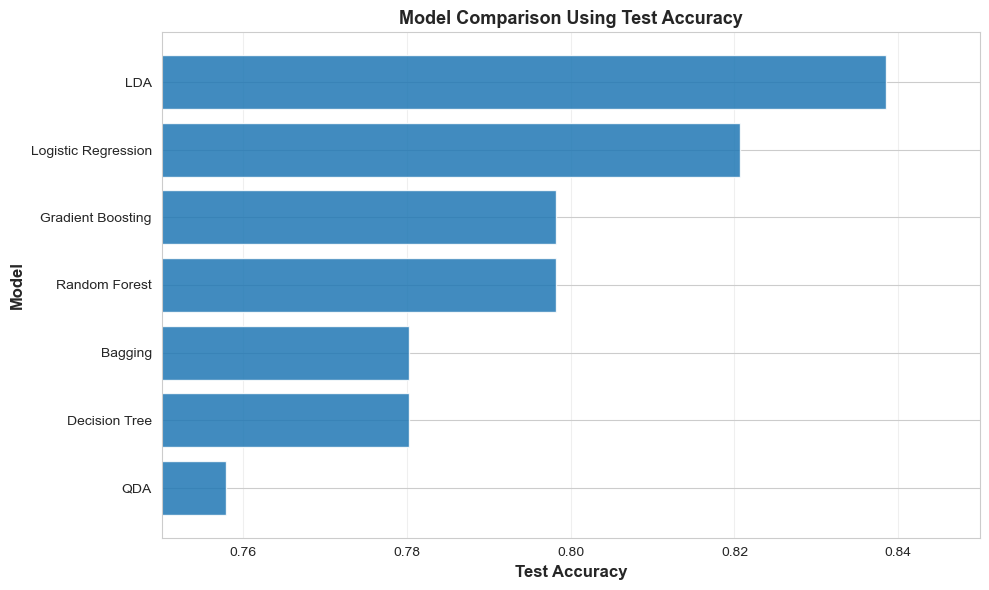

In [79]:

test_acc_df = results_df[['Model', 'Test_Accuracy']].sort_values('Test_Accuracy', ascending=True)

print(test_acc_df)

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

plt.barh(
    test_acc_df['Model'],
    test_acc_df['Test_Accuracy'],
    alpha=0.85
)

plt.xlabel('Test Accuracy', fontsize=12, fontweight='bold')
plt.ylabel('Model', fontsize=12, fontweight='bold')
plt.title('Model Comparison Using Test Accuracy', fontsize=13, fontweight='bold')

plt.xlim(0.75, 0.85)  # adjust if needed
plt.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

